## MACHINE LEARNING BASED SPAM EMAIL DETECTION

The objective of this project is to build a ML based email spam detector application. We are going to use 4 machine learning algorithms (Logistic regression, Support vector machine classifier (SVM), Random forest, Gradient boosting classifier) to classify the dateset containing spam and ham emails into their respective labels.

* We start with exploring the data and understanding the structure of the emails and their content. 
* The data is then cleaned by removing any punctuation or special characters so these don't contribute to the noise in the model.
* We then define a few functions to convert all the email content to plain text and build a dataframe out of it.
* Then we proceed to build the machine learning models by vectorizing the text using the TFIDF vectorizer and feeding the data into them.
* Since the data classes are unbalanced we evaluate each model based on different performance metrics (majorly the F-1 score and the AUC ROC scores). After selecting the best model, it is finally evaluated on the test set. 

We observed that SVM-TFIDF vectorizer model perofomed the best with:
Precision:0.939,
Recall:0.991,
F1 score:0.964,
accuracy:0.989515,
AUC:0.990027.

The summary of the classification performance of all the mmodels used is as follows:

| Model     | Precision | Recall  | F1 | Accuracy |AUC|
| ----------- | ----------- |--  |--|--|--|
| TFIDF vectorizer with LogisticRegression      | 1.000       |0.972   |0.986  |0.996068  |0.986111  |
| TFIDF vectorizer with SVM   | 0.939        |  0.991 |0.964  | 0.989515 |0.990027  |
| TFIDF Vectorizer with Random Forest Classifier            |  1.000           | 0.935   | 0.967 |0.99082  | 0.967593 |
| TFIDF Vectorizer with GradientBoosting Classifier            |   0.812          |   0.880 | 0.844 |0.954128  | 0.923021 |


### Importing required libraries

In [173]:
import numpy as np
import pandas as pd
import os
import email
import email.policy
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from tqdm.notebook import tqdm 


## Exploratory data analysis 

#### Checking the structure of our data
How many ham/spam emails does our dataset contain?

In [100]:
ham_filenames = [name for name in sorted(os.listdir('ham')) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir('spam')) if len(name) > 20]
print('Total number of ham emails: ',len(ham_filenames))
print('Total number of spam emails: ',len(spam_filenames))
print('Spam proportion: ',100*(len(spam_filenames)/(len(ham_filenames)+len(spam_filenames))))

Total number of ham emails:  2551
Total number of spam emails:  501
Spam proportion:  16.41546526867628


#### Checking the structure of a sample email

In [99]:
#Using email.parser: https://docs.python.org/3/library/email.parser.html
#"The email package provides a standard parser that understands most email document structures, including MIME documents"

with open(os.path.join('ham', ham_filenames[0]), "rb") as file:
    ham_email =  email.parser.BytesParser(policy=email.policy.default).parse(file)

print('Header field names: ',ham_email.keys())
print('\n \n')
print('Message field values: ',ham_email.values())
print('\n \n')
print('Message content:',ham_email.get_content()[:500])

Header field names:  ['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Received', 'Received', 'From', 'To', 'Cc', 'Subject', 'In-Reply-To', 'References', 'MIME-Version', 'Content-Type', 'Message-Id', 'X-Loop', 'Sender', 'Errors-To', 'X-Beenthere', 'X-Mailman-Version', 'Precedence', 'List-Help', 'List-Post', 'List-Subscribe', 'List-Id', 'List-Unsubscribe', 'List-Archive', 'Date']

 

Message field values:  ['<exmh-workers-admin@example.com>', 'zzzz@localhost.netnoteinc.com', 'from localhost (localhost [127.0.0.1])\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)', 'from phobos [127.0.0.1]\tby localhost with IMAP (fetchmail-5.9.0)\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)', 'from listman.example.com (listman.example.com [66.187.233.211]) by    dogma.slashnull.org (8.11.6/8.11.6) with ESM

In [9]:
#Let's try and extract some objects in the emails

email_subject = ham_email.get_all('Subject')
email_from = ham_email.get_all('From')
email_to = ham_email.get_all('To')

print('Email from: ',email_from)
print('Email to: ',email_to)
print('Email subject: ',email_subject)

Email from:  ['Robert Elz <kre@munnari.OZ.AU>']
Email to:  ['Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>']
Email subject:  ['Re: New Sequences Window']


In [103]:
def extract_ham(filename):
    """This function process a ham email file located at a specified directory and returns it as an email object"""
    with open(os.path.join('ham', filename), "rb") as file:
        return email.parser.BytesParser(policy=email.policy.default).parse(file)

def extract_spam(filename):
    """This function process a spam email file located at a specified directory and returns it as an email object"""
    with open(os.path.join('spam', filename), "rb") as file:
        return email.parser.BytesParser(policy=email.policy.default).parse(file)
    
ham_emails = [extract_ham(filename=ham) for ham in ham_filenames]
spam_emails = [extract_spam(filename=spam) for spam in spam_filenames]

In [104]:
#Checking if the data is extracted properly

print(ham_emails[0].get_all('Subject'))
print(ham_emails[0].get_content())
print('\n\n -----------------------------------------------------------\n\n')
print(spam_emails[1].get_all('Subject'))
print(spam_emails[1].get_content())

['Re: New Sequences Window']
    Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs

## Converting emails to plain text
We can observe from the above code cell that there are some emails with the HTML format. We need to convert them to plain text.

In [105]:
#checking for the content types in the emails

ham_email_types = []
spam_email_types = []

for i in range(len(ham_filenames)):
    ham_email_types.append(ham_emails[i].get_content_type())

for i in range(len(spam_filenames)):
    spam_email_types.append(spam_emails[i].get_content_type())

print('Ham content types: ',set(ham_email_types))
print('Spam content types: ',set(spam_email_types))

Ham content types:  {'multipart/signed', 'multipart/report', 'multipart/mixed', 'text/plain', 'multipart/related', 'multipart/alternative'}
Spam content types:  {'multipart/mixed', 'text/plain', 'multipart/related', 'multipart/alternative', 'text/html'}


#### checking the structure of these multipart emails

In [106]:
def email_content_type(email):
    """This function returns the content type of an email and if it has a multipart shape then returns the multiparts type"""
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([email_content_type(sub_email) for sub_email in payload]))
    else:
        return email.get_content_type()

In [21]:
ham_email_types = []
spam_email_types = []

for i in range(len(ham_filenames)):
    ham_email_types.append(email_content_type(ham_emails[i]))

for i in range(len(spam_filenames)):
    spam_email_types.append(email_content_type(spam_emails[i]))

print('Ham content types: ',set(ham_email_types))

print('\n')

print('Spam content types: ',set(spam_email_types))

Ham content types:  {'multipart(text/plain, text/enriched)', 'multipart(text/plain, application/octet-stream)', 'multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))', 'multipart(text/plain, application/x-pkcs7-signature)', 'multipart(text/plain, video/mng)', 'multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)', 'multipart(text/plain)', 'multipart(text/plain, text/html)', 'multipart(text/plain, application/pgp-signature)', 'text/plain', 'multipart(text/plain, multipart(text/plain))', 'multipart(text/plain, application/ms-tnef, text/plain)', 'multipart(text/plain, text/plain)', 'multipart(text/plain, application/x-java-applet)', 'multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)'}


Spam content types:  {'multipart(text/plain, application/octet-stream)', 'multipart(text/html, text/plain)', 'multipart(text/html, application/octet-stream)', 'multipart(multipart

#### Transforming all html emails to plain text format using BeautifulSoup

In [109]:
#testing BS on a sample email
from bs4 import BeautifulSoup
html = spam_emails[8].get_content()
soup = BeautifulSoup(html)
print(soup.get_text().replace('\n\n',''))

ReliaQuote - Save Up To 70% On Life Insurance
 
Life
                                can change in an instant. That's why it is so
                                important to protect your family's financial future
                                with sufficient life insurance coverage.State
                          of Residence:Select State
Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Dist. of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming
Date
                          of Birth (MM/DD/YY):
 MM
01
02
03
04
05
06
07
08
09
10
11
12                          /
                          
DD
01
02
03
04
05
0

#### Defining a function to convert all html emails to plain text

In [115]:
def html_to_text(email):
    soup = BeautifulSoup(email.get_content())
    return soup.get_text().replace('\n\n','').replace('\n',' ') 

#### Converting all the email objects to plain text

In [113]:
#Now all emails which have/contain HTML tags will be converted to plain text

def email_to_text(email):
    content_type = email_content_type(email)
    for part in email.walk(): 
        #The .walk() documentation at https://docs.python.org/3/library/email.message.html
        #"The walk() method is an all-purpose generator which can be used to iterate over all 
        #the parts and subparts of a message object tree, in depth-first traversal order."
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: 
            partContent = str(part.get_payload())
        if partContentType == 'text/plain':
            return partContent
        else:
            return html_to_text(part)

#### Testing the function on a sample email

In [120]:
email_1 = email_to_text(spam_emails[1])
print(email_1)

Save up to 70% on Life Insurance. Why Spend More Than You Have To?Life Quote Savings Ensuring your        family's financial security is very important. Life Quote Savings makes        buying life insurance simple and affordable. We Provide FREE Access to The        Very Best Companies and The Lowest Rates.Life Quote Savings is FAST, EASY and              SAVES you money! Let us help you get started with the best values in              the country on new coverage. You can SAVE hundreds or even thousands              of dollars by requesting a FREE quote from Lifequote Savings. Our              service will take you less than 5 minutes to complete. Shop and              compare. SAVE up to 70% on all types of Life insurance! Click Here For Your              Free Quote!Protecting your family is the best investment you'll ever            make! If you are in receipt of this email        in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMOVE. If you        resid

In [152]:
#Spam email #226 contains an unknown encoding so we will remove it from the list
del spam_emails[226]

## Building the dataframe to train the model

we can create a dataframe with the email's content and their particular label. We will use this dataframe in implementing NLP to feed data into the model

In [153]:
ham_data = []
spam_data = []

#processing HAM data
for i in range(len(ham_emails)):
    ham_data.append(email_to_text(ham_emails[i]))
ham_data = pd.DataFrame(ham_data,columns=['Email content'])
ham_data['Label'] = 0

#processing SPAM data
for i in range(len(spam_emails)):
    spam_data.append(email_to_text(spam_emails[i]))
spam_data = pd.DataFrame(spam_data,columns=['Email content'])
spam_data['Label'] = 1

df = pd.concat([ham_data,spam_data])
df.head()

,Email content,Label
0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
1,"Martin A posted:\nTassos Papadopoulos, the Gre...",0
2,Man Threatens Explosion In Moscow \n\nThursday...,0
3,Klez: The Virus That Won't Die\n \nAlready the...,0
4,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrot...",0


In [154]:
df.shape

(3050, 2)

In [155]:
df = df.dropna()
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Email content,Label
0,"\nAfter my latest cvs up, timtest fails with\n...",0
1,"On 27 Aug 2002 at 15:00, Rohit Khare wrote:\n>...",0
2,Opportunity is knocking. Why?\n\nBecause mortg...,1
3,> From: Anders Eriksson <aeriksson@fastmail.f...,0
4,Never Pay Retail! You can count on Blair.com...,1


In [156]:
df.shape

(3049, 2)

### Cleaning the dataset
Removing the special characeters to avoid clutter and degradation of model performance.

In [157]:
for i in range(len(df)):
    df.at[i,'Email content'] = df.loc[i]['Email content'].replace('!','').replace('?','').replace(',','').replace('[','').replace(']','').replace('(','').replace(')','').replace('...','')
    df.at[i,'Email content'] = df.loc[i]['Email content'].replace('>','').replace('<','').replace('\n',' ').replace('-','').replace('+','').replace('#','')
df.head()

,Email content,Label
0,After my latest cvs up timtest fails with ...,0
1,On 27 Aug 2002 at 15:00 Rohit Khare wrote: ...,0
2,Opportunity is knocking. Why Because mortgage...,1
3,From: Anders Eriksson aeriksson@fastmail.fm ...,0
4,Never Pay Retail You can count on Blair.com ...,1


#### Splitting the dataset into train and test sets

In [158]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Email content'],df['Label'],shuffle=True,random_state=0)

In [159]:
print (len(X_train),len(X_test),len(y_train),len(y_test))

2286 763 2286 763


## Model training and selection
We'll go through the use of TfidfVectorizer and CountVectorizer as NLP resources to transform the dataset into a format the classifiers can interpret. 

We are going to train a LogisticRegressor and a Support Vector classifier with TFIDF  vectorizer and the best model will be evaluated on the test data.

In [160]:
# Defining a function to compute Precision, Recall and F1 score,accuracy and auc roc score on the test set

def get_pre_rec_f1_accuracy_auc(model,X_test,y_test):
    y_test_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    auc = roc_auc_score(y_test, y_test_pred)
    
    print(f'Precision:{precision:.3f}\nRecall:{recall:.3f}\nF1 score:{F1:.3f}\naccuracy:{accuracy:3f}\nAUC:{auc:3f}')

### TFIDF vectorizer with LogisticRegression

In [200]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=10000))
# running the grid search takes a long time because of the relatively large grid and the inclusion of trigrams
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
"tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3),(2,5),(1,5),(1,4)]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.99
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 5)}


In [201]:
vect = TfidfVectorizer(min_df=5,ngram_range=(1,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
clf_lg = LogisticRegression(C=100,max_iter=10000).fit(X_train_vectorized, y_train)
y_predicted = clf_lg.predict(X_test_vectorized)

In [202]:
get_pre_rec_f1_accuracy_auc(clf_lg,X_test_vectorized,y_test)

Precision:1.000
Recall:0.972
F1 score:0.986
accuracy:0.996068
AUC:0.986111


### TFIDF vectorizer with SVC.

In [244]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
param_grid = {'C':[100,1000,10000],'gamma':[0.1,0.001,0.0001], 'kernel':['linear','rbf']}
grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)
grid.fit(X_train_vectorized, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   1.4s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   1.6s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   1.6s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   1.6s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   1.6s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   1.8s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   1.8s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   1.8s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   1.8s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   1.7s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   1.4s
[CV] END ..................C=100, gamma=0.001, k

In [248]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
clf_svc = SVC(C=10000,gamma= 0.001,kernel='rbf').fit(X_train_vectorized, y_train)
y_predicted = clf_svc.predict(X_test_vectorized)

In [249]:
get_pre_rec_f1_accuracy_auc(clf_svc,X_test_vectorized,y_test)

Precision:0.939
Recall:0.991
F1 score:0.964
accuracy:0.989515
AUC:0.990027


### TFIDF Vectorizer with Random Forest Classifier

In [216]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
param_grid = {'max_depth':[2,5,10,20,30,50,100,200],'n_estimators':[20,50,200,400,600,1000]}
grid = GridSearchCV(RandomForestClassifier(random_state=0),param_grid,refit = True, verbose=2)
grid.fit(X_train_vectorized, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=20; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ......................max_depth=2, n_estimators=200; total time=   0.2s
[CV] END ......................max_depth=2, n_e

[CV] END .....................max_depth=20, n_estimators=200; total time=   0.7s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.7s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.7s
[CV] END .....................max_depth=20, n_estimators=200; total time=   0.7s
[CV] END .....................max_depth=20, n_estimators=400; total time=   1.4s
[CV] END .....................max_depth=20, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=20, n_estimators=400; total time=   1.4s
[CV] END .....................max_depth=20, n_estimators=400; total time=   1.6s
[CV] END .....................max_depth=20, n_estimators=400; total time=   1.5s
[CV] END .....................max_depth=20, n_estimators=600; total time=   2.3s
[CV] END .....................max_depth=20, n_estimators=600; total time=   2.2s
[CV] END .....................max_depth=20, n_estimators=600; total time=   2.2s
[CV] END ...................

[CV] END ....................max_depth=100, n_estimators=600; total time=   4.2s
[CV] END ....................max_depth=100, n_estimators=600; total time=   4.4s
[CV] END ...................max_depth=100, n_estimators=1000; total time=   7.4s
[CV] END ...................max_depth=100, n_estimators=1000; total time=   7.5s
[CV] END ...................max_depth=100, n_estimators=1000; total time=   7.3s
[CV] END ...................max_depth=100, n_estimators=1000; total time=   7.1s
[CV] END ...................max_depth=100, n_estimators=1000; total time=   7.4s
[CV] END .....................max_depth=200, n_estimators=20; total time=   0.1s
[CV] END .....................max_depth=200, n_estimators=20; total time=   0.1s
[CV] END .....................max_depth=200, n_estimators=20; total time=   0.1s
[CV] END .....................max_depth=200, n_estimators=20; total time=   0.1s
[CV] END .....................max_depth=200, n_estimators=20; total time=   0.1s
[CV] END ...................

In [252]:
vect = TfidfVectorizer(min_df=5,ngram_range=(1,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
clf_rf = RandomForestClassifier(n_estimators=50,max_depth=200,random_state=0).fit(X_train_vectorized, y_train)
y_predicted = clf_rf.predict(X_test_vectorized)

In [253]:
get_pre_rec_f1_accuracy_auc(clf_rf,X_test_vectorized,y_test)

Precision:1.000
Recall:0.935
F1 score:0.967
accuracy:0.990826
AUC:0.967593


### TFIDF Vectorizer with GradientBoosting Classifier

In [256]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
param_grid = {'max_depth':[30,50,100,200]}
grid = GridSearchCV(GradientBoostingClassifier(random_state=0,n_estimators=50),param_grid,refit = True, verbose=2)
grid.fit(X_train_vectorized, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .......................................max_depth=30; total time=  21.0s
[CV] END .......................................max_depth=30; total time=  21.7s
[CV] END .......................................max_depth=30; total time=  21.0s
[CV] END .......................................max_depth=30; total time=  20.3s
[CV] END .......................................max_depth=30; total time=  21.4s
[CV] END .......................................max_depth=50; total time=  29.5s
[CV] END .......................................max_depth=50; total time=  32.2s
[CV] END .......................................max_depth=50; total time=  31.4s
[CV] END .......................................max_depth=50; total time=  32.3s
[CV] END .......................................max_depth=50; total time=  29.4s
[CV] END ......................................max_depth=100; total time=  23.5s
[CV] END ......................................ma

In [259]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
clf_gbm = GradientBoostingClassifier(max_depth=30,random_state=0).fit(X_train_vectorized, y_train)
y_predicted = clf_gbm.predict(X_test_vectorized)

In [260]:
get_pre_rec_f1_accuracy_auc(clf_gbm,X_test_vectorized,y_test)

Precision:0.812
Recall:0.880
F1 score:0.844
accuracy:0.954128
AUC:0.923021


### Model selected: Support Vector Classifier with TFIDF vectorizer.
SVC with TFIDF vectorizer has the highest AUC score and hence selected as the best model

In [261]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
clf_svc = SVC(C=10000,gamma= 0.001,kernel='rbf').fit(X_train_vectorized, y_train)
y_predicted = clf_svc.predict(X_test_vectorized)

In [272]:
get_pre_rec_f1_accuracy_auc(clf_svc,X_test_vectorized,y_test)

Precision:0.939
Recall:0.991
F1 score:0.964
accuracy:0.989515
AUC:0.990027


#### The SVC-TFIDF vectorizer model peroforms really well on this dataset as seen from the AUC score of 0.99.

In [273]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Features with highest idf:\n{}".format(vect.get_feature_names()[-100:]))

Vocabulary size: 32236
Features with highest idf:
['your private valuable', 'your private valuable information', 'your private valuable information allow', 'your problem', 'your profits', 'your profits once', 'your profits once you', 'your profits once you understand', 'your progress', 'your progress by', 'your progress by watching', 'your progress by watching which', 'your questions', 'your reports', 'your reports today', 'your reports today and', 'your reports today and get', 'your request', 'your return', 'your return address', 'your return address is', 'your return address is on', 'your right', 'your right to', 'your road', 'your road to', 'your road to financial', 'your running', 'your sales', 'your sendmail', 'your services', 'your shirt', 'your site', 'your success', 'your success guidelines', 'your success guidelines follow', 'your success guidelines follow these', 'your success if', 'your success if you', 'your success if you do', 'your system', 'your system norton', 'your sys

## Confusion Matrix

In [263]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
matrix = confusion_matrix(y_test, y_predicted)

### Normalizing and displaying the confusion matrix 

<ipython-input-271-30dde9c2a154>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


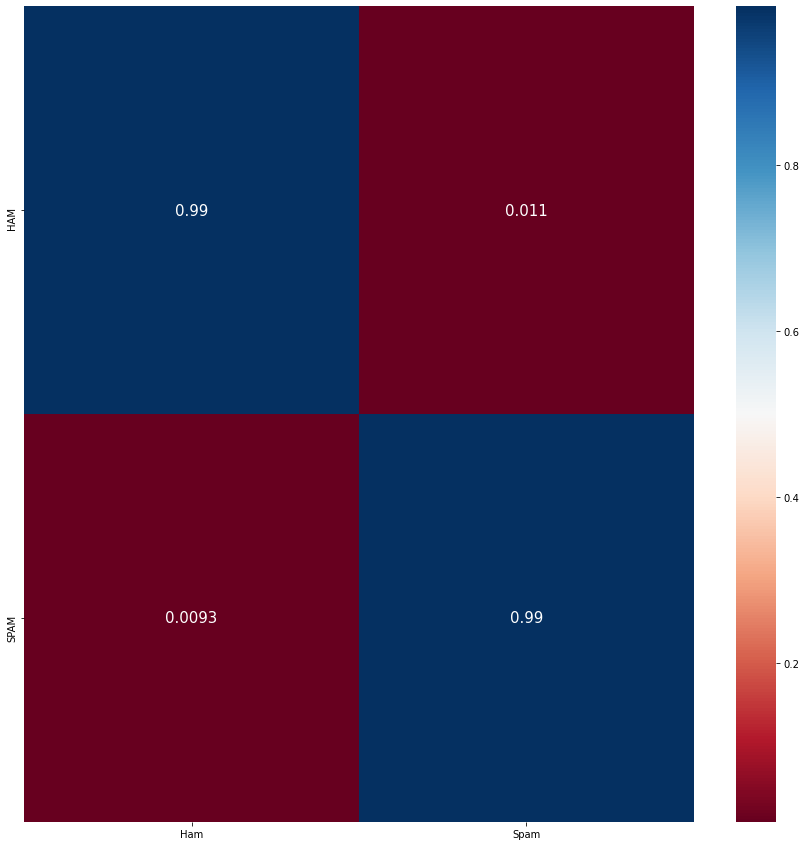

In [271]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['HAM','SPAM'],columns = ['Ham','Spam'])
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15},cmap='RdBu')
plt.show()

## Model testing
Let's simulate some emails to see how our model performs

#### Defining a function to remove punctuations from the mail content for the predictions

In [267]:
def input_preprocessing(text):
    text = text.replace('!','').replace('?','').replace(',','').replace('[','').replace(']','').replace('(','').replace(')','').replace('...','')
    text = text.replace('>','').replace('<','').replace('\n',' ').replace('-','').replace('+','').replace('#','')
    return text

#### Testing the trained SVC model on a sample of emails

In [268]:
email_test = ['Good morning mates. This is just to let you all know we have scheduled a meeting for EOD.']
email_test[0] = input_preprocessing(email_test[0])
email_test = vect.transform(email_test)
prediction = clf_svc.predict(email_test)

if prediction == 0:
    print('The email has not been flagged as SPAM.')
else:
    print('The email has been flagged as SPAM.')

The email has not been flagged as SPAM.


In [270]:
email_test = ['Dear Sergio, Flash Sale at Walmart! 25% OFF all weekend!']
email_test[0] = input_preprocessing(email_test[0])
email_test = vect.transform(email_test)
prediction = clf_svc.predict(email_test)

if prediction == 0:
    print('The email has not been flagged as SPAM.')
else:
    print('The email has been flagged as SPAM.')

The email has been flagged as SPAM.
